In [4]:
import yfinance as yf

stock_tickers =['META', 'NFLX', 'TSLA']

database = yf.download(stock_tickers,start='2012-01-01',end ='2021-12-30')
database = database['Adj Close']
data = database.dropna().pct_change(1).dropna()
data

[*********************100%***********************]  3 of 3 completed


Ticker,META,NFLX,TSLA
Date,,,
2012-05-21 00:00:00+00:00,-0.109861,0.025443,0.043904
2012-05-22 00:00:00+00:00,-0.089039,-0.056175,0.070559
2012-05-23 00:00:00+00:00,0.032258,0.062029,0.007143
2012-05-24 00:00:00+00:00,0.032188,-0.022806,-0.023855
2012-05-25 00:00:00+00:00,-0.033909,-0.000711,-0.015522
...,...,...,...
2021-12-22 00:00:00+00:00,-0.011221,0.015407,0.074947
2021-12-23 00:00:00+00:00,0.014495,-0.000244,0.057619
2021-12-27 00:00:00+00:00,0.032633,-0.001580,0.025248


In [5]:
import numpy as np
import pandas as pd
import scipy


def sk_Criterion(weight,data):
    Lambda = 3
    W = 1
    Wbar = (1+0.25)/100
    
    portfolio_return = np.multiply(data,np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    mean = np.mean(portfolio_return,axis=0)
    std = np.std(portfolio_return,axis=0)
    sk = scipy.stats.skew(portfolio_return,axis=0)
    kurt = scipy.stats.kurtosis(portfolio_return,axis=0)
    
    mv_crite = (Wbar**-1-Lambda)/1+Lambda + (Wbar**-Lambda)*W*mean - 0.5*Lambda*(W**2)*(std**2)*Wbar**(-1-Lambda) 
    
    criterion = mv_crite + ((Lambda*(Lambda+1))/6)*(W**3)*(Wbar**-2-Lambda)*sk -((Lambda*(Lambda+1)*(Lambda+2))/24)*(W**4)*(Wbar**-3-Lambda)*kurt
    criterion = -1*criterion
    
    return criterion
    

In [7]:
import numpy as np
from scipy.optimize import minimize

validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

n = data.shape[1]
x0 = np.ones(n)

cons = ({'type':'eq','fun':lambda x:np.sum(abs(x))-1})
Bounds = [(0,1) for i in range(0,n)]
res = minimize(sk_Criterion,x0,args = train_data,method='SLSQP',constraints= cons,bounds=Bounds,options={'disp':True})
res_weight = res.x

optimal_portfolio_return = np.multiply(test_data,np.transpose(res_weight))
optimal_portfolio_return = optimal_portfolio_return.sum(axis=1)

res_weight


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3535918.1284672646
            Iterations: 13
            Function evaluations: 58
            Gradient evaluations: 13


array([0.33881365, 0.21543241, 0.44575395])

In [8]:
from statistics import covariance
import pandas as pd

def beta_function(portfolio,ben = "^GSPC"):
    benchmarck = yf.download(ben)["Adj Close"]
    benchmarck = benchmarck.dropna().pct_change(1)
    join = pd.concat((portfolio,benchmarck), axis=1).dropna()
    
    cov = np.cov(join,rowvar=False)[0][1]
    var = np.cov(join,rowvar = False)[1][1]
    
    return cov/var


print(beta_function(optimal_portfolio_return,ben="^GSPC"))

[*********************100%***********************]  1 of 1 completed

1.1019350712807114


In [9]:
#alpha function
def alpha_function(portfolio,ben = "^GSPC",timeframe = 252):
    benchmarck = yf.download(ben)["Adj Close"]
    benchmarck = benchmarck.dropna().pct_change(1)
    join = pd.concat((portfolio,benchmarck), axis=1).dropna()
    
    beta = beta_function(optimal_portfolio_return,ben=ben)
    mean_stock_return =join.iloc[:,0].mean()*timeframe
    mean_market_return = join.iloc[:,1].mean()*timeframe
    
    alpha = mean_stock_return - beta*mean_market_return
    return alpha
    
print(alpha_function(optimal_portfolio_return,ben = "^GSPC",timeframe = 252))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

0.4637047309590443


In [10]:
#Sharpe function

def sharpe_function(portfolio,timeframe = 252):
    mean = portfolio.mean()*timeframe
    std = portfolio.std()*np.sqrt(timeframe)
    return mean/std

print("Sharpe Ratio is"+" ",sharpe_function(optimal_portfolio_return,timeframe=252))

Sharpe Ratio is  1.7484984208389631


In [11]:
#Sortino function

def sortino_function(portfolio,timeframe =252):
    mean = portfolio.mean()*timeframe
    std = portfolio[portfolio<0].std()*np.sqrt(timeframe)
    return  mean/std

print("Sortino Ratio is"+" ",sortino_function(optimal_portfolio_return,timeframe=252))

Sortino Ratio is  2.2936536089694823


In [12]:
#Drawdown function
def drawdown_function(portfolio):
    cum_ret =(portfolio+1).cumprod()
    running_max = np.maximum.accumulate((cum_ret.dropna()))
    running_max[running_max<1] = 1
    
    return (cum_ret/running_max)-1


print("drawdown"+" ",drawdown_function(optimal_portfolio_return))

drawdown  Date
2019-02-13 00:00:00+00:00   -0.012102
2019-02-14 00:00:00+00:00   -0.014218
2019-02-15 00:00:00+00:00   -0.012528
2019-02-19 00:00:00+00:00   -0.013152
2019-02-20 00:00:00+00:00   -0.018210
                               ...   
2021-12-22 00:00:00+00:00   -0.099133
2021-12-23 00:00:00+00:00   -0.071618
2021-12-27 00:00:00+00:00   -0.051221
2021-12-28 00:00:00+00:00   -0.054102
2021-12-29 00:00:00+00:00   -0.058078
Length: 726, dtype: float64


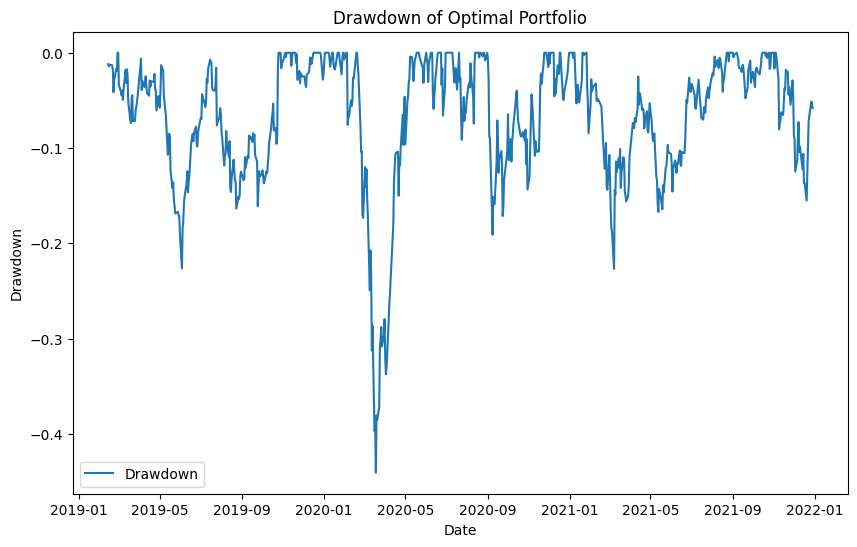

In [13]:
import matplotlib.pyplot as plt

# Calculate drawdown
drawdown = drawdown_function(optimal_portfolio_return)

# Plot drawdown
plt.figure(figsize=(10, 6))
plt.plot(drawdown, label='Drawdown')
plt.title('Drawdown of Optimal Portfolio')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()